### Analysis of algorithm performance across datasets and metrics for NeurIPS submission

For these tables we use the meta-dataset as for the RecZilla pipeline.

In [321]:
import pandas as pd
import numpy as np

# make a plot
import matplotlib.pyplot as plt
import matplotlib as mpl

In [324]:
# updated to use v3a (including some neural methods)

df = pd.read_pickle("./meta_datasets/metadata-v3a.pkl")

# drop this alg - not useful
df = df.loc[df["alg_family"] != "MFBPR_Wrapper", :]


### Basic metrics, number of experiments, etc

There are 88 total dataset splits and 18 algs used during training.

In [325]:
with open("./all_datasets.txt", 'r') as f:
    lines = f.readlines()
    all_dataset_list = [l.strip() for l in lines]

print(f"num datasets: {len(all_dataset_list)}")

num datasets: 88


In [326]:
print(f"number of datasets with results: {len(df['dataset_name'].unique())}")
print(f"number of algs with results: {len(df['alg_family'].unique())}")
print(f"number of results: {len(df)}")

number of datasets with results: 85
number of algs with results: 24
number of results: 84829


In [327]:
# df['dataset_name'].unique()

In [328]:
print("number of rows for each alg family")
print(df.groupby(["alg_family"]).size())

number of rows for each alg family
alg_family
CoClustering                           5106
DELF_EF_RecommenderWrapper               10
DELF_MLP_RecommenderWrapper              10
EASE_R_Recommender                     4376
GlobalEffects                            85
IALSRecommender                        3502
INeuRec_RecommenderWrapper                8
ItemKNNCF                             12847
MatrixFactorization_AsySVD_Cython      4254
MatrixFactorization_BPR_Cython         5659
MatrixFactorization_FunkSVD_Cython     4938
Mult_VAE_RecommenderWrapper              18
NMFRecommender                         2957
P3alphaRecommender                     5816
PureSVDRecommender                     6132
RP3betaRecommender                     5900
Random                                   85
SLIMElasticNetRecommender              4706
SLIM_BPR_Cython                        5176
SlopeOne                                 48
SpectralCF_RecommenderWrapper             7
TopPop                        

In [329]:
dataset_expt_counts = df.groupby(["dataset_name"]).size()

# add datasets that aren't present..
for dataset in all_dataset_list:
    if dataset + "Reader" not in dataset_expt_counts:
        dataset_expt_counts[dataset] = 0
        print(f"no results for dataset: {dataset}")



no results for dataset: AmazonBooks
no results for dataset: AmazonPurchaseCircles
no results for dataset: GoogleLocalReviews


In [330]:
dataset_expt_counts.median()

1220.5

In [331]:
### get min, median, and max runtime for each alg
agg_dict_time = {
    "time_on_train": ["min", "mean", "max"],
    # "time_on_val": ["min", "mean", "max"],
    "time_on_test": ["min", "mean", "max"],    
    "alg_family": ["size"],    
}
df_runtime = df.groupby("alg_family").agg(agg_dict_time)

# write to latex table
# export table 2
tex_name = f"./tables/runtime_table.tex"
csv_name = f"./tables/runtime_table.csv"
df_runtime.to_csv(csv_name, index=True)
with open(tex_name, "w") as f:
    df_runtime.to_latex(f, index=True, escape=False, float_format="%.2f")
print(f"wrote table to csv: {csv_name} and tex: {tex_name}")

wrote table to csv: ./tables/runtime_table.csv and tex: ./tables/runtime_table.tex


In [332]:
df_runtime

time_on_train                              \
                                             min          mean           max   
alg_family                                                                     
CoClustering                            0.017557    167.452175  25766.229633   
DELF_EF_RecommenderWrapper             23.941439  10182.523096  37874.628458   
DELF_MLP_RecommenderWrapper            23.435324   9493.476673  37403.214535   
EASE_R_Recommender                      0.002660     13.849628    454.139277   
GlobalEffects                           0.002471      0.430198     12.728573   
IALSRecommender                         0.690905    369.297258  24283.544810   
INeuRec_RecommenderWrapper             86.884388  15524.709300  39790.344894   
ItemKNNCF                               0.002062    100.283757  13617.510515   
MatrixFactorization_AsySVD_Cython       0.025652    207.755339  28463.527275   
MatrixFactorization_BPR_Cython          0.022732     82.185424   9635.263668   
MatrixFactorization_FunkSVD_Cython      0.023347    172.606193  15650.111933   
Mult_VAE_RecommenderWrapper            10.679080   4496.702536  37286.484591   
NMFRecommender                          0.006802    221.503106  20369.452757   
P3alphaRecommender                      0.002743     78.167283   6264.473410   
PureSVDRecommender                      0.003427      3.580843    353.117155   
RP3betaRecommender                      0.002807     80.449131   7043.173153   
Random                                  0.001203      0.087618      2.351918   
SLIMElasticNetRecommender               0.059865    142.951411  25731.735380   
SLIM_BPR_Cython                         0.028665     82.574888  31063.867415   
SlopeOne                                0.048464     17.728445    470.274466   
SpectralCF_RecommenderWrapper          20.646341    346.514358   1516.798759   
TopPop                                  0.001328      0.127093      3.660060   
UNeuRec_RecommenderWrapper            228.478923   4440.093372   9489.378996   
UserKNNCF                               0.001711     73.278972  30975.030312   

                                   time_on_test                             \
                                            min         mean           max   
alg_family                                                                   
CoClustering                           0.054886    51.086023  11393.358884   
DELF_EF_RecommenderWrapper             1.511744  1287.822864   5642.562606   
DELF_MLP_RecommenderWrapper            1.495512  1263.306639   5647.987131   
EASE_R_Recommender                     0.053583    14.990186    341.970452   
GlobalEffects                          0.052444   639.580678   8191.357315   
IALSRecommender                        0.054589    10.255598   3558.969311   
INeuRec_RecommenderWrapper             0.160030     5.534368     21.606593   
ItemKNNCF                              0.050831   159.028128   8192.899661   
MatrixFactorization_AsySVD_Cython      0.054751    40.368085  13293.735288   
MatrixFactorization_BPR_Cython         0.055468    69.988056  12117.408730   
MatrixFactorization_FunkSVD_Cython     0.054467    50.488467  12793.543738   
Mult_VAE_RecommenderWrapper            0.107153   143.841859    961.889490   
NMFRecommender                         0.055974    87.415148  11471.295282   
P3alphaRecommender                     0.054138    62.403027   6563.457628   
PureSVDRecommender                     0.052609    99.062664  10393.312854   
RP3betaRecommender                     0.052987    61.238623   7067.746515   
Random                                 0.056785   937.672544  16529.636103   
SLIMElasticNetRecommender              0.053670    11.629995   1816.687042   
SLIM_BPR_Cython                        0.053819    21.893782   1962.253756   
SlopeOne                               0.066031    45.771332    803.246600   
SpectralCF_RecommenderWrapper          0.120156     6.163021     22.799316   
To

### Calculate best metric for each dataset split, over all algs + hyperparam sets.

In [333]:
## print all metric cols
#  for c in df.columns:
#     if "_metric_" in c:
#         print(c)

In [334]:
# define a subset of metrics to focus on

cuts = [1, 2, 5, 10, 50]
metrics = ["NDCG", "PRECISION", "RECALL", "PRECISION_RECALL_MIN_DEN", "F1", "MAP", "MAP_MIN_DEN", "ARHR_ALL_HITS", "MRR", "HIT_RATE", "COVERAGE_ITEM_HIT"]
metric_list = []
metric_list = []
metric_name_map = dict()
for metric in metrics:
    for cut in cuts:
        # add test metrics
        metric_list.append(f"test_metric_{metric}_cut_{str(cut)}")
        metric_name_map[f"test_metric_{metric}_cut_{str(cut)}"] = f"{metric}@{cut}"
        # # add val metrics
        # metric_list.append(f"val_metric_{metric}_cut_{str(cut)}")
        # metric_name_map[f"val_metric_{metric}_cut_{str(cut)}"] = f"{metric}@{cut}"
print(metric_list)

['test_metric_NDCG_cut_1', 'test_metric_NDCG_cut_2', 'test_metric_NDCG_cut_5', 'test_metric_NDCG_cut_10', 'test_metric_NDCG_cut_50', 'test_metric_PRECISION_cut_1', 'test_metric_PRECISION_cut_2', 'test_metric_PRECISION_cut_5', 'test_metric_PRECISION_cut_10', 'test_metric_PRECISION_cut_50', 'test_metric_RECALL_cut_1', 'test_metric_RECALL_cut_2', 'test_metric_RECALL_cut_5', 'test_metric_RECALL_cut_10', 'test_metric_RECALL_cut_50', 'test_metric_PRECISION_RECALL_MIN_DEN_cut_1', 'test_metric_PRECISION_RECALL_MIN_DEN_cut_2', 'test_metric_PRECISION_RECALL_MIN_DEN_cut_5', 'test_metric_PRECISION_RECALL_MIN_DEN_cut_10', 'test_metric_PRECISION_RECALL_MIN_DEN_cut_50', 'test_metric_F1_cut_1', 'test_metric_F1_cut_2', 'test_metric_F1_cut_5', 'test_metric_F1_cut_10', 'test_metric_F1_cut_50', 'test_metric_MAP_cut_1', 'test_metric_MAP_cut_2', 'test_metric_MAP_cut_5', 'test_metric_MAP_cut_10', 'test_metric_MAP_cut_50', 'test_metric_MAP_MIN_DEN_cut_1', 'test_metric_MAP_MIN_DEN_cut_2', 'test_metric_MAP_MIN_

In [335]:
dataset_col = "dataset_name"

# get global min and max values for each metric, for each dataset
agg_dict = {
    metric: ["min", "max"]
    for metric in metric_list
}
dataset_metric_bounds = df.groupby(dataset_col).agg(agg_dict).reset_index()
dataset_alg_metric_bounds = df.groupby([dataset_col, "alg_family"]).agg(agg_dict).reset_index()

# move to single index - first for global
new_col_names = []
for v in dataset_metric_bounds.columns.values:
    if v[1] in ['min', 'max']:
        new_col_names.append('overall_' + v[1] + '_' + v[0])
    else:
        new_col_names.append(v[0])
        
dataset_metric_bounds.columns = new_col_names

# move to single index - now for dataset-specific
new_col_names = []
for v in dataset_alg_metric_bounds.columns.values:
    if v[1] in ['min', 'max']:
        new_col_names.append(v[1] + '_' + v[0])
    else:
        new_col_names.append(v[0])

dataset_alg_metric_bounds.columns = new_col_names

# now merge in dataset-specific metric bounds with dataset+alg metric bounds
df_expt = dataset_alg_metric_bounds.merge(dataset_metric_bounds, on=dataset_col, how="inner")

# now calculate normalized metric value for each metric
for metric in metric_list:
    df_expt.loc[:, "normalized_" + metric] = (df_expt["max_" + metric] - df_expt["overall_min_" + metric]) / (df_expt["overall_max_" + metric] - df_expt["overall_min_" + metric])

In [336]:
# spot-check: display the metrics for a handful of algs on a handful of datasets

display_alg_names = [
    "GlobalEffects",
    "Random",
    "TopPop",
    "NMFRecommender",
    "ItemKNNCF",
    "UserKNNCF"
]
max_metric_list = ["max_" + metric for metric in metric_list]

display_dataset_names = [
    "Movielens1MReader",
    "RecipesReader",
    "AmazonAppliancesReader",
]



for metric_col in max_metric_list:
    print(f"metric = {metric}")
    df_pivot = pd.pivot(df_display, values=metric_col, index="alg_family", columns="dataset_name")
    print(df_pivot)
    print("\n")
# # df_pivot = pd.pivot(df_display, values=metric_list, index=["alg_family", "dataset_name"])
# print(df_pivot)
    


metric = test_metric_COVERAGE_ITEM_HIT_cut_50
dataset_name    AmazonAppliancesReader  Movielens1MReader  RecipesReader
alg_family                                                              
GlobalEffects                 0.001265           0.002981       0.000000
ItemKNNCF                     0.009488           0.029972       0.003637
NMFRecommender                0.004428           0.014406       0.001353
Random                        0.000000           0.000166       0.000000
TopPop                        0.003163           0.009604       0.001466
UserKNNCF                     0.003163           0.011095       0.000423


metric = test_metric_COVERAGE_ITEM_HIT_cut_50
dataset_name    AmazonAppliancesReader  Movielens1MReader  RecipesReader
alg_family                                                              
GlobalEffects                 0.003260           0.004234       0.000125
ItemKNNCF                     0.009653           0.041046       0.004580
NMFRecommender                

In [395]:
# spot check 2: look at all algs, for NDCG@50, for amazon-home imporovement
metric = "max_test_metric_NDCG_cut_50"
print(df_expt.loc[df_expt["dataset_name"] == "AmazonHomeImprovementReader", ["alg_family", metric]].sort_values(metric))



                             alg_family  max_test_metric_NDCG_cut_50
565                              Random                     0.000000
555          INeuRec_RecommenderWrapper                     0.014461
551         DELF_MLP_RecommenderWrapper                     0.014713
552                  EASE_R_Recommender                     0.014713
568                            SlopeOne                     0.014713
566           SLIMElasticNetRecommender                     0.014713
562                  P3alphaRecommender                     0.014713
564                  RP3betaRecommender                     0.014713
569       SpectralCF_RecommenderWrapper                     0.017780
567                     SLIM_BPR_Cython                     0.019446
560         Mult_VAE_RecommenderWrapper                     0.022135
556                           ItemKNNCF                     0.022875
571          UNeuRec_RecommenderWrapper                     0.022889
553                       GlobalEf

calculate ranks of all algs based on the normalized metrics

In [337]:
# how many nans are there for each metric?
for c in dataset_alg_metric_bounds.columns:
    print(f"{c}: {sum(dataset_alg_metric_bounds[c].isna())}")


dataset_name: 0
alg_family: 0
min_test_metric_NDCG_cut_1: 5
max_test_metric_NDCG_cut_1: 5
min_test_metric_NDCG_cut_2: 8
max_test_metric_NDCG_cut_2: 8
min_test_metric_NDCG_cut_5: 9
max_test_metric_NDCG_cut_5: 9
min_test_metric_NDCG_cut_10: 9
max_test_metric_NDCG_cut_10: 9
min_test_metric_NDCG_cut_50: 15
max_test_metric_NDCG_cut_50: 15
min_test_metric_PRECISION_cut_1: 0
max_test_metric_PRECISION_cut_1: 0
min_test_metric_PRECISION_cut_2: 0
max_test_metric_PRECISION_cut_2: 0
min_test_metric_PRECISION_cut_5: 0
max_test_metric_PRECISION_cut_5: 0
min_test_metric_PRECISION_cut_10: 0
max_test_metric_PRECISION_cut_10: 0
min_test_metric_PRECISION_cut_50: 0
max_test_metric_PRECISION_cut_50: 0
min_test_metric_RECALL_cut_1: 0
max_test_metric_RECALL_cut_1: 0
min_test_metric_RECALL_cut_2: 0
max_test_metric_RECALL_cut_2: 0
min_test_metric_RECALL_cut_5: 0
max_test_metric_RECALL_cut_5: 0
min_test_metric_RECALL_cut_10: 0
max_test_metric_RECALL_cut_10: 0
min_test_metric_RECALL_cut_50: 0
max_test_metric_REC

In [338]:
# get the rank of each alg within each dataset, for each metric
for metric in metric_list:
    # rank within dataset
    df_expt.loc[:, "rank_" + metric] = df_expt.groupby([dataset_col])["normalized_" + metric].rank(method="min", ascending=False).values


## Correlation between metrics, over all datasets and algs

In [339]:
# normalized_metrics = ["normalized_" + m for m in metric_list if "NDCG" in m or "MAP" in m or "PRECISION" in m]
# metric_names = [metric_name_map[m] for m in metric_list if "NDCG" in m or "MAP" in m]
corr_mat = df_expt.loc[:, ["normalized_" + m for m in metric_list]].corr()
metric_name_list = [metric_name_map[m] for m in metric_list]

In [340]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# m = ax.matshow(corr_mat)
# fig.colorbar(m)
# xaxis = np.arange(len(corr_mat.columns))
# ax.set_xticks(xaxis)
# ax.set_yticks(xaxis)
# ax.set_xticklabels(metric_name_list, fontsize=14, rotation=45)
# ax.set_yticklabels(metric_name_list, fontsize=14)



In [341]:
# corr_mat.columns

## Table 1: show rank and normalized metrics for all algs, and a sample of datasets

In [342]:

# include cols for these datasets
display_datasets = [
    "Movielens1MReader",
    "Movielens100KReader",
    "Movielens20MReader"
    "AmazonMoviesTVReader",
    "AmazonLuxuryBeautyReader",
    "AmazonWineReader"
    "BookCrossingReader",
    "YahooMoviesReader",
    "CiaoDVDReader",
    "MovieTweetingsReader",
    "AnimeReader",
    "DatingReader",
    # "LastFMReader",  # many NaNs...
    "NetflixPrizeReader",
]

for metric_name in metric_list:

    display_metric = "normalized_" + metric_name
    display_rank = "rank_" + metric_name

    df_expt.loc[:, "display_text"] = df_expt.apply(lambda x: "{:.0f} ({:.2f})".format(x[display_rank], x[display_metric]), axis=1)

    table_1 = df_expt[df_expt["dataset_name"].isin(display_datasets)].pivot(index="alg_family", columns="dataset_name", values="display_text").reset_index()

    new_col_names = [c if ~c.endswith("Reader") else c[:-len("Reader")] for c in table_1.columns]
    new_col_names[0] = "Alg."
    table_1.columns = new_col_names
    
    # export table 1
    csv_name = f"./tables/table_1_{metric_name}.csv"
    tex_name = f"./tables/table_1_{metric_name}.tex"
    table_1.to_csv(csv_name, index=False)
    with open(tex_name, "w") as f:
        table_1.to_latex(f, index=False)
    print(f"wrote table to csv: {csv_name} and tex: {tex_name}")


wrote table to csv: ./tables/table_1_test_metric_NDCG_cut_1.csv and tex: ./tables/table_1_test_metric_NDCG_cut_1.tex
wrote table to csv: ./tables/table_1_test_metric_NDCG_cut_2.csv and tex: ./tables/table_1_test_metric_NDCG_cut_2.tex
wrote table to csv: ./tables/table_1_test_metric_NDCG_cut_5.csv and tex: ./tables/table_1_test_metric_NDCG_cut_5.tex
wrote table to csv: ./tables/table_1_test_metric_NDCG_cut_10.csv and tex: ./tables/table_1_test_metric_NDCG_cut_10.tex
wrote table to csv: ./tables/table_1_test_metric_NDCG_cut_50.csv and tex: ./tables/table_1_test_metric_NDCG_cut_50.tex
wrote table to csv: ./tables/table_1_test_metric_PRECISION_cut_1.csv and tex: ./tables/table_1_test_metric_PRECISION_cut_1.tex
wrote table to csv: ./tables/table_1_test_metric_PRECISION_cut_2.csv and tex: ./tables/table_1_test_metric_PRECISION_cut_2.tex
wrote table to csv: ./tables/table_1_test_metric_PRECISION_cut_5.csv and tex: ./tables/table_1_test_metric_PRECISION_cut_5.tex
wrote table to csv: ./tables/t

## Table 2: show max and min rank over all datasets for each metric.

In [343]:
# first show the number of algs with results for each dataset and each metric. (equal to max rank)
# only keep datasets which have at least 10 ranked algs for each metric
max_rank_table = df_expt.groupby("dataset_name")[["rank_" + m for m in metric_list]].max().reset_index()
drop_datasets = []
for c in max_rank_table.columns[1:]:
    if max_rank_table[c].min() < 10:
        # print(f"WARNING: column {c} has a dataset with only {max_rank_table[c].min()} algs")
        # print(max_rank_table[max_rank_table[c] < 10][["dataset_name", c]])
        # print(f"adding to drop_datasets...")
        drop_datasets.extend(max_rank_table[max_rank_table[c] < 10]["dataset_name"])

drop_datasets = set(drop_datasets)
print(f"datasets to drop: {drop_datasets}")

df_table_2 = df_expt.loc[~df_expt["dataset_name"].isin(drop_datasets), :]

print(f"remaining datasets: {len(df_table_2['dataset_name'].unique())}")
print(df_table_2['dataset_name'].unique())


datasets to drop: {'FrappeReader', 'AmazonFolkReader', 'AmazonRockReader', 'AmazonAllElectronicsReader', 'AmazonWineReader', 'LastFMReader', 'AmazonHardRockMetalReader', 'AmazonOfficeSchoolSuppliesReader', 'AmazonMP3PlayersAccessoriesReader', 'AmazonCountryReader', 'AmazonNewAgeReader', 'AmazonRBReader', 'GowallaReader', 'AmazonCollectiblesFineArtReader', 'AmazonLatinMusicReader', 'AmazonAllBeautyReader', 'AmazonRapHipHopReader', 'AmazonGospelReader', 'AmazonBluesReader', 'AmazonPopReader', 'AmazonAppstoreforAndroidReader', 'AmazonHomeImprovementReader', 'YahooMusicReader', 'AmazonComputersReader', 'AmazonInternationalReader', 'AmazonAlternativeRockReader'}
remaining datasets: 59
['AmazonAmazonFashionReader' 'AmazonAmazonInstantVideoReader'
 'AmazonAppliancesReader' 'AmazonAppsforAndroidReader'
 'AmazonArtsCraftsSewingReader' 'AmazonAutomotiveReader'
 'AmazonBabyProductsReader' 'AmazonBabyReader' 'AmazonBeautyReader'
 'AmazonBuyaKindleReader' 'AmazonCDsVinylReader'
 'AmazonCellPhonesAc

In [344]:
df_table_2["alg_family"].unique()

array(['CoClustering', 'GlobalEffects', 'IALSRecommender', 'ItemKNNCF',
       'MatrixFactorization_AsySVD_Cython',
       'MatrixFactorization_BPR_Cython',
       'MatrixFactorization_FunkSVD_Cython', 'NMFRecommender',
       'P3alphaRecommender', 'PureSVDRecommender', 'RP3betaRecommender',
       'Random', 'SLIMElasticNetRecommender', 'SLIM_BPR_Cython', 'TopPop',
       'UserKNNCF', 'EASE_R_Recommender', 'SlopeOne',
       'Mult_VAE_RecommenderWrapper', 'DELF_EF_RecommenderWrapper',
       'DELF_MLP_RecommenderWrapper', 'INeuRec_RecommenderWrapper',
       'SpectralCF_RecommenderWrapper', 'UNeuRec_RecommenderWrapper'],
      dtype=object)

In [385]:
keep_alg_map = {
    "ItemKNNCF": {
        "name": "Item-KNN",
        "plt-kwargs": {"marker":"x", "color":"r", "linestyle":"--"}
    },
    "UserKNNCF": {
        "name": "User-KNN",
        "plt-kwargs": {"marker":"+", "color":"r", "linestyle":"--"}
    },
    "RP3betaRecommender": {
        "name": "RP3beta",
        "plt-kwargs": {"marker":"*", "color":"r", "linestyle":"--"}
    },
    "P3alphaRecommender": {
        "name": "RP3beta",
        "plt-kwargs": {"marker":"*", "color":"r", "linestyle":"--"}
    },
    "IALSRecommender": {"name": "iALS"},
    "EASE_R_Recommender": {"name": "EASE-R"},
    "SlopeOne": {"name": "SlopeOne"},
    "CoClustering": {"name": "CoClustering"},
    "MatrixFactorization_AsySVD_Cython": {"name": "MF-AsySVD"},
    "MatrixFactorization_FunkSVD_Cython": {"name": "MF-FunkSVD"},
    "PureSVDRecommender": {"name": "SVD"},
    "NMFRecommender": {"name": "NMF"},
    "INeuRec_RecommenderWrapper": {
        "name": "I-neural",
    },
    "UNeuRec_RecommenderWrapper": {
        "name": "U-neural",
        "plt-kwargs": {"marker":"^", "color":"gray", "linestyle":"--"}
    },
    "SpectralCF_RecommenderWrapper": {
        "name": "Spectral-CF"},
    "DELF_MLP_RecommenderWrapper": { "name": "DELF-MLP"},
        "DELF_EF_RecommenderWrapper": { "name": "DELF-EF"},
        "Mult_VAE_RecommenderWrapper": { "name": "Mult-VAE",
                "plt-kwargs": {"marker":"v", "color":"gray", "linestyle":"--"}
},
    "MatrixFactorization_BPR_Cython":
    {
        "name": "MF-BPR",
        "plt-kwargs": {"marker":"D", "color":"g", "linestyle":":"}
    },
    "IALSRecommender": {
        "name": "iALS",
        "plt-kwargs": {"marker":"o", "color":"g", "linestyle":":"}
    },
    "SLIM_BPR_Cython": {
        "name": "SLIM-BPR",
        "plt-kwargs": {"marker":"X", "color":"blue", "linestyle":"-."}
    },
    "SLIMElasticNetRecommender": {
        "name": "SLIM-ElasticNet",
        "plt-kwargs": {"marker":"P", "color":"blue", "linestyle":"-."}
    },
    "GlobalEffects":{
        "name": "GlobalEffects",
        "plt-kwargs": {"marker":">", "color":"black", "linestyle":"-"}
    },
    "TopPop": {
        "name": "TopPop",
        "plt-kwargs": {"marker":"<", "color":"black", "linestyle":"-"}
    },
    "Random":{
        "name": "Random",
        "plt-kwargs": {"marker":">", "color":"black", "linestyle":"-"}
    },
}
keep_algs = list(keep_alg_map.keys())
alg_names = [v["name"] for v in keep_alg_map.values()]

# keep_algs = list(df_table_2["alg_family"].unique())

# get min and max rank for each alg and each metric over all algs.     each alg = col, row = metric
agg_dict = {
    "rank_" + metric: lambda x: "{:.0f}/{:.0f} ({:.1f})".format(min(x), max(x), np.mean(x)) for metric in metric_list
}
table_2_transpose = df_table_2[df_table_2["alg_family"].isin(keep_algs)].groupby("alg_family").agg(agg_dict).reset_index()

table_2 = table_2_transpose.transpose().copy()
new_cols = list(table_2.iloc[0,:])
table_2.columns = new_cols
table_2.drop(labels=("alg_family"), inplace=True)  # drop the first row, which is the alg name

# add the order ing
table_2.loc[:, "order"] = 0
for i, metric in enumerate(metric_list):
    table_2.at["rank_" + metric, "order"] = i

# now fix the metric names
new_index = []
for index_label in table_2.index:
    new_index.append(metric_name_map[index_label[len("rank_"):]])
table_2.index = new_index


In [386]:
# bookkeeping - order the rows
final_table_2 = table_2.sort_values("order").drop(columns="order")

# # order the cols
# final_table_2 = final_table_2.reindex(columns=keep_algs)

# # bookeeping - rename the cols
# new_col_names = ["\\rot{" + keep_alg_map[c]["name"] + "}" for c in final_table_2.columns]
# final_table_2.columns = new_col_names


In [387]:
# export table 2, in 3 parts

# ---- non-neural methods ---

# order the cols
tab = final_table_2.reindex(columns=[
    "ItemKNNCF",
    "UserKNNCF",
    "RP3betaRecommender",
    "P3alphaRecommender",
    "IALSRecommender",
    "EASE_R_Recommender",
    "SlopeOne",
    "CoClustering",
    ])

# bookeeping - rename the cols
new_col_names = ["\\rot{" + keep_alg_map[c]["name"] + "}" for c in tab.columns]
tab.columns = new_col_names

csv_name = f"./tables/table_2a.csv"
tex_name = f"./tables/table_2a.tex"
tab.to_csv(csv_name, index=True)
with open(tex_name, "w") as f:
    tab.to_latex(f, index=True, escape=False)
print(f"wrote table to csv: {csv_name} and tex: {tex_name}")

# --- baseline methods ---


tab = final_table_2.reindex(columns=[
    "MatrixFactorization_AsySVD_Cython",
    "MatrixFactorization_FunkSVD_Cython",
    "PureSVDRecommender",
    "NMFRecommender",
    "MatrixFactorization_BPR_Cython",
    "SLIM_BPR_Cython",
    "SLIMElasticNetRecommender",
    ])

# bookeeping - rename the cols
new_col_names = ["\\rot{" + keep_alg_map[c]["name"] + "}" for c in tab.columns]
tab.columns = new_col_names

csv_name = f"./tables/table_2b.csv"
tex_name = f"./tables/table_2b.tex"
tab.to_csv(csv_name, index=True)
with open(tex_name, "w") as f:
    tab.to_latex(f, index=True, escape=False)
print(f"wrote table to csv: {csv_name} and tex: {tex_name}")


# --- neural methods ---

tab = final_table_2.reindex(columns=[
    "INeuRec_RecommenderWrapper",
    "UNeuRec_RecommenderWrapper",
    "SpectralCF_RecommenderWrapper",
    "DELF_MLP_RecommenderWrapper",
    "DELF_EF_RecommenderWrapper",
    "Mult_VAE_RecommenderWrapper",
    "GlobalEffects",
    "TopPop",
    "Random",
    ])

# bookeeping - rename the cols
new_col_names = ["\\rot{" + keep_alg_map[c]["name"] + "}" for c in tab.columns]
tab.columns = new_col_names

csv_name = f"./tables/table_2c.csv"
tex_name = f"./tables/table_2c.tex"
tab.to_csv(csv_name, index=True)
with open(tex_name, "w") as f:
    tab.to_latex(f, index=True, escape=False)
print(f"wrote table to csv: {csv_name} and tex: {tex_name}")



wrote table to csv: ./tables/table_2a.csv and tex: ./tables/table_2a.tex
wrote table to csv: ./tables/table_2b.csv and tex: ./tables/table_2b.tex
wrote table to csv: ./tables/table_2c.csv and tex: ./tables/table_2c.tex


### Plot 1: plot change in metric across dataset for select algs
- each line in the series is an alg
- horizontal axis = datasets
- vertical axis = normalized metric

In [414]:
plot_alg_map = keep_alg_map

plot_algs = [
    "ItemKNNCF",
    "UserKNNCF",
    # "RP3betaRecommender",
    "UNeuRec_RecommenderWrapper",
    "Mult_VAE_RecommenderWrapper",
    "MatrixFactorization_BPR_Cython",
    "IALSRecommender",
    "SLIM_BPR_Cython",
    "SLIMElasticNetRecommender",
    "GlobalEffects",
    "TopPop",
    "Random",
]

plot_alg_names = [v["name"] for v in keep_alg_map.values()]

plot_dataset_map = {
    # 'AmazonLuxuryBeautyReader': "Amz-Lux",
    # 'AmazonMiscellaneousReader': "Amz-Misc",
    # 'AmazonMusicalInstrumentsReader',
    # 'AmazonVideoGamesReader',
    'AmazonMoviesTVReader': "Amz-MovieTV",
    'AmazonHomeImprovementReader': "Amz-HomeImprv",
    'AnimeReader': "Anime",
    'BookCrossingReader': "BookCross",
    'CiaoDVDReader': "CiaoDVD",
    'EpinionsReader': "Epinions",
    'FilmTrustReader': "FilmTrust",
    # 'DatingReader',
    'Jester2Reader': "Jester",
    # 'MarketBiasAmazonReader': "MktBias-El",
    'MarketBiasModClothReader': "MktBias-Mod",
    'MovieTweetingsReader': "MvTweet",
    'Movielens100KReader': "Mvlns-100K",
    'Movielens10MReader': "Mvlns-10M",
    # 'Movielens1MReader': "Mvlns-1M",
    # 'Movielens20MReader',
    'MovielensHetrec2011Reader': "Mvlns-Hetrec",
    # 'NetflixPrizeReader',
    'RecipesReader': "Recipes",
    'WikilensReader': "Wikilens",
    'YahooMoviesReader': "YahooMv",
}
plot_datasets = list(plot_dataset_map.keys())
plot_dataset_names = list(plot_dataset_map.values())

In [415]:
plot_metric_map = {
    "normalized_" + "test_metric_PRECISION_cut_50":  "PREC@50",
    "normalized_" + "test_metric_COVERAGE_ITEM_HIT_cut_10":  "COV-ITEM-HIT@10",
    # "normalized_" + "test_metric_MAP_cut_10": "MAP@10",
    "normalized_" + "test_metric_NDCG_cut_5": "NDCG@5",
    #  "normalized_" + "test_metric_NDCG_cut_2",
    # "normalized_" + "test_metric_RECALL_cut_10": "Norm. RECALL@10",
}
plot_metric_list = list(plot_metric_map.keys())


data = dict()

for metric_name in plot_metric_list:
    data[metric_name] = dict()
    for alg in plot_algs:
        data[metric_name][alg] = []
        for dataset in plot_datasets:
            vals = df_expt.loc[(df_expt["alg_family"] == alg) & (df_expt["dataset_name"] == dataset), metric_name].values
            if len(vals) != 1:
                print(f"there's an issue with {alg}-{dataset}-{metric_name}")
                print(vals)
                val = None
            else:
                val = vals[0]
            data[metric_name][alg].append(val)
    


# df_table_2

there's an issue with UNeuRec_RecommenderWrapper-AmazonMoviesTVReader-normalized_test_metric_PRECISION_cut_50
[]
there's an issue with UNeuRec_RecommenderWrapper-AnimeReader-normalized_test_metric_PRECISION_cut_50
[]
there's an issue with UNeuRec_RecommenderWrapper-BookCrossingReader-normalized_test_metric_PRECISION_cut_50
[]
there's an issue with UNeuRec_RecommenderWrapper-CiaoDVDReader-normalized_test_metric_PRECISION_cut_50
[]
there's an issue with UNeuRec_RecommenderWrapper-EpinionsReader-normalized_test_metric_PRECISION_cut_50
[]
there's an issue with UNeuRec_RecommenderWrapper-MovieTweetingsReader-normalized_test_metric_PRECISION_cut_50
[]
there's an issue with UNeuRec_RecommenderWrapper-Movielens10MReader-normalized_test_metric_PRECISION_cut_50
[]
there's an issue with UNeuRec_RecommenderWrapper-MovielensHetrec2011Reader-normalized_test_metric_PRECISION_cut_50
[]
there's an issue with UNeuRec_RecommenderWrapper-RecipesReader-normalized_test_metric_PRECISION_cut_50
[]
there's an 

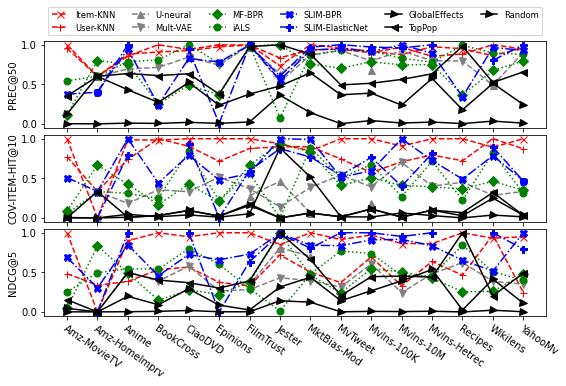

In [416]:
fig, ax = plt.subplots(len(plot_metric_list), 1, sharex=True, figsize=(8, 5))

for i, metric in enumerate(plot_metric_list):
    for alg in plot_algs:    
        ax[i].plot(data[metric][alg], label=plot_alg_map[alg]["name"], markersize=7, **plot_alg_map[alg]["plt-kwargs"])
    ax[i].set_ylabel(plot_metric_map[metric])

ax[i].set_xticks(np.arange(len(plot_dataset_names)))
ax[i].set_xticklabels(plot_dataset_names, rotation=-35, ha='left', rotation_mode='anchor')

plt.tight_layout()
plt.subplots_adjust(hspace=0.08)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, 3.6), ncol=6, fontsize="small")
# plt.show()
plt.savefig("./fig/squiggly.pdf", bbox_inches='tight')

# Table 3: rank over all datasets, all metrics...

In [224]:
# get mean, max, and min for each alg, over **all** datasets and **all** metrics. Only consider metrics: NDCG, precision, recall, Prec.-Rec.-Min-density, hit-rate, F1, MAP, MAP-Min-density, ARHR, and MRR
tab3_metrics = ["NDCG", "PRECISION", "RECALL", "PRECISION_RECALL_MIN_DEN", "F1", "MAP", "MAP_MIN_DEN", "ARHR_ALL_HITS", "MRR", "HIT_RATE"]

# keep rank columns -- only use these
keep_rank_cols = []
for c in df_table_2.columns:
    if c.startswith("rank_"):
        for m in tab3_metrics:
            if m in c:
                keep_rank_cols.append(c)

print("rank columns used:")
print(keep_rank_cols)


rank columns used:
['rank_test_metric_NDCG_cut_1', 'rank_test_metric_NDCG_cut_2', 'rank_test_metric_NDCG_cut_5', 'rank_test_metric_NDCG_cut_10', 'rank_test_metric_NDCG_cut_50', 'rank_test_metric_PRECISION_cut_1', 'rank_test_metric_PRECISION_cut_2', 'rank_test_metric_PRECISION_cut_5', 'rank_test_metric_PRECISION_cut_10', 'rank_test_metric_PRECISION_cut_50', 'rank_test_metric_RECALL_cut_1', 'rank_test_metric_RECALL_cut_2', 'rank_test_metric_RECALL_cut_5', 'rank_test_metric_RECALL_cut_10', 'rank_test_metric_RECALL_cut_50', 'rank_test_metric_PRECISION_RECALL_MIN_DEN_cut_1', 'rank_test_metric_PRECISION_RECALL_MIN_DEN_cut_1', 'rank_test_metric_PRECISION_RECALL_MIN_DEN_cut_1', 'rank_test_metric_PRECISION_RECALL_MIN_DEN_cut_2', 'rank_test_metric_PRECISION_RECALL_MIN_DEN_cut_2', 'rank_test_metric_PRECISION_RECALL_MIN_DEN_cut_2', 'rank_test_metric_PRECISION_RECALL_MIN_DEN_cut_5', 'rank_test_metric_PRECISION_RECALL_MIN_DEN_cut_5', 'rank_test_metric_PRECISION_RECALL_MIN_DEN_cut_5', 'rank_test_metr

In [295]:
# melt the df for table 3
df_table_3_melt = pd.melt(df_table_2, id_vars=["alg_family", "dataset_name"], value_vars=keep_rank_cols)

# groupby to get mean, max, min rank over all datasets and metrics
df_table_3 = df_table_3_melt.groupby("alg_family").agg({"value": ["min", "max", "mean"], "dataset_name": lambda x: len(set(x))}).reset_index()

# df_table_3.columns = df_table_3.columns.droplevel(0)
df_table_3.columns = ["Alg.", "Min", "Max", "Mean", "Num. Datasets"]

print(df_table_3)


                                  Alg.   Min   Max       Mean  Num. Datasets
0                         CoClustering   1.0  22.0  14.732794             57
1           DELF_EF_RecommenderWrapper   7.0  19.0  14.371429              7
2          DELF_MLP_RecommenderWrapper  19.0  25.0  22.134066              7
3                   EASE_R_Recommender   1.0  17.0   5.137892             27
4                        GlobalEffects   2.0  19.0  13.049283             59
5                      IALSRecommender   1.0  20.0   6.980769             56
6           INeuRec_RecommenderWrapper  10.0  19.0  15.409231              5
7                            ItemKNNCF   1.0  12.0   2.278227             59
8                        MFBPR_Wrapper   6.0  24.0  17.737557             17
9    MatrixFactorization_AsySVD_Cython   1.0  18.0  10.514949             53
10      MatrixFactorization_BPR_Cython   1.0  19.0  11.009549             58
11  MatrixFactorization_FunkSVD_Cython   1.0  16.0   9.224934             58

In [296]:
# rearrange
final_table_3 = df_table_3.transpose().reset_index()

new_cols = final_table_3.iloc[0].values
final_table_3.columns = new_cols
final_table_3 = final_table_3.iloc[1:]

In [301]:
table_3_keep_alg_map = {
    "ItemKNNCF": {
        "name": "Item-KNN",
    },
    "UserKNNCF": {
        "name": "User-KNN",
    },
    "RP3betaRecommender": {
        "name": "RP3beta",
    },
    "INeuRec_RecommenderWrapper": {
        "name": "I-neural",
    },
    "UNeuRec_RecommenderWrapper": {
        "name": "U-neural",
    },
    "SpectralCF_RecommenderWrapper": {
        "name": "Spectral-CF"},
    # "MFBPR_Wrapper": { "name": "MF-BPR"},
    "DELF_MLP_RecommenderWrapper": { "name": "DELF-MLP"},
        "DELF_EF_RecommenderWrapper": { "name": "DELF-EF"},
        "Mult_VAE_RecommenderWrapper": { "name": "Mult-VAE"},
    "P3alphaRecommender":{
        "name": "P3alpha",
    },
    "MatrixFactorization_BPR_Cython":
    {
        "name": "MF-BPR",
    },
    "IALSRecommender": {
        "name": "iALS",
    },
    "SLIM_BPR_Cython": {
        "name": "SLIM-BPR",
    },
    "SLIMElasticNetRecommender": {
        "name": "SLIM-ElasticNet",
    },
    "GlobalEffects":{
        "name": "GlobalEffects",
    },
    "TopPop": {
        "name": "TopPop",
    },
    "Random":{
        "name": "Random",
    },
}


table_3_neural_alg_map = {
    "INeuRec_RecommenderWrapper": {
        "name": "I-neural",
    },
    "UNeuRec_RecommenderWrapper": {
        "name": "U-neural",
    },
    "SpectralCF_RecommenderWrapper": {
        "name": "Spectral-CF"},
    "DELF_MLP_RecommenderWrapper": { "name": "DELF-MLP"},
        "DELF_EF_RecommenderWrapper": { "name": "DELF-EF"},
        "Mult_VAE_RecommenderWrapper": { "name": "Mult-VAE"},
}


alg_order = list(table_3_keep_alg_map.keys())
alg_order_neural = list(table_3_neural_alg_map.keys())

# --- non-neural methods ---

# order the cols
final_table_3_latex = final_table_3.reindex(columns=alg_order)

# # bookeeping - rename the cols
new_col_names = ["\\rot{" + table_3_keep_alg_map[c]["name"] + "}" for c in final_table_3_latex.columns]
final_table_3_latex.columns = new_col_names

# export table
csv_name = f"./tables/table_3_nonneural.csv"
tex_name = f"./tables/table_3_nonneural.tex"
final_table_3_latex.to_csv(csv_name, index=False)
with open(tex_name, "w") as f:
    final_table_3_latex.to_latex(f, index=False)
print(f"wrote table to csv: {csv_name} and tex: {tex_name}")

# --- neural methods ---

# order the cols
final_table_3_neural_latex = final_table_3.reindex(columns=alg_order_neural)

# # bookeeping - rename the cols
new_col_names = ["\\rot{" + table_3_neural_alg_map[c]["name"] + "}" for c in final_table_3_neural_latex.columns]
final_table_3_neural_latex.columns = new_col_names

# export table
csv_name = f"./tables/table_3_neural.csv"
tex_name = f"./tables/table_3_neural.tex"
final_table_3_neural_latex.to_csv(csv_name, index=False)
with open(tex_name, "w") as f:
    final_table_3_neural_latex.to_latex(f, index=False)
print(f"wrote table to csv: {csv_name} and tex: {tex_name}")


wrote table to csv: ./tables/table_3_nonneural.csv and tex: ./tables/table_3_nonneural.tex
wrote table to csv: ./tables/table_3_neural.csv and tex: ./tables/table_3_neural.tex


In [412]:
# now write a version of table 3 with both neural and non-neural methods
table_3_final_alg_map = {
    "ItemKNNCF": {
        "name": "Item-KNN",
    },
        "P3alphaRecommender": {
        "name": "P3alpha",
    },
    "SLIM_BPR_Cython": {
        "name": "SLIM-BPR",
    },
      "RP3betaRecommender": {
        "name": "RP3beta",
    },

        "SLIMElasticNetRecommender": {
        "name": "SLIM-ElasticNet",
    },
    "IALSRecommender": {
        "name": "iALS",
    },
        "UserKNNCF": {
        "name": "User-KNN",
    },
        "TopPop": {
        "name": "TopPop",
    },
    "MatrixFactorization_BPR_Cython":
    {
        "name": "MF-BPR",
    },
    "Mult_VAE_RecommenderWrapper": { "name": "Mult-VAE"},
    "UNeuRec_RecommenderWrapper": {
        "name": "U-neural",
    },
        "GlobalEffects":{
        "name": "GlobalEffects",
    },
    "CoClustering": {
        "name": "CoClustering",
    },
    "Random":{
        "name": "Random",
    },
}

alg_order = list(table_3_final_alg_map.keys())

# --- neural methods ---

# order the cols
final_table_3_final_latex = final_table_3.reindex(columns=alg_order)

# # bookeeping - rename the cols
new_col_names = ["\\rot{" + table_3_final_alg_map[c]["name"] + "}" for c in final_table_3_final_latex.columns]
final_table_3_final_latex.columns = new_col_names

# export table
csv_name = f"./tables/table_3_final.csv"
tex_name = f"./tables/table_3_final.tex"
final_table_3_final_latex.to_csv(csv_name, index=False)
with open(tex_name, "w") as f:
    final_table_3_final_latex.to_latex(f, index=False)
print(f"wrote table to csv: {csv_name} and tex: {tex_name}")


wrote table to csv: ./tables/table_3_final.csv and tex: ./tables/table_3_final.tex


In [413]:
final_table_3_final_latex

,\rot{Item-KNN},\rot{P3alpha},\rot{SLIM-BPR},\rot{RP3beta},\rot{SLIM-ElasticNet},\rot{iALS},\rot{User-KNN},\rot{TopPop},\rot{MF-BPR},\rot{Mult-VAE},\rot{U-neural},\rot{GlobalEffects},\rot{CoClustering},\rot{Random}
1,1,1,1,1,1,1,1,1,1,4,6,2,1,9
2,12,19,14,18,17,20,18,19,19,24,19,19,22,24
3,2.27823,4.19568,4.62033,5.92255,6.67564,6.98077,7.61721,10.157,11.0095,11.95,12.0646,13.0493,14.7328,15.8785
4,59,57,56,58,36,56,59,59,58,16,5,59,57,59
